In [1]:
from typing import Literal

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import grad
import matplotlib.pyplot as plt
from torcheval.metrics import R2Score


from src.train.model.mlp import MLP
from src.train.model_component import ModelComponent
from src.train.sampler.rect_sampler import RectBoundarySampler
from src.train.trainer import TrainConfig, Trainer
from src.train.pipeline import Pipeline
from src.train.preprocessor.min_max_scaler import MinMaxScaler
from src.utils.device_setup import get_device

/Users/june/Documents/project/cau/4_2/ez_pinn/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_component = ModelComponent(
    name="wave_1d_mlp",
    model=MLP(
        activation_functions="tanh",
        model_architecture=[2, 32, 16, 16, 32, 1],
    ),
)

# Dataset

In [3]:
class TXSampler(RectBoundarySampler):
    def __init__(self, domain_t, domain_x, boundary_sample_count):
        super().__init__(domain_t, domain_x, boundary_sample_count)

    def sample(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns (x, t) sampling points

        Returns:
            tuple: (domain, initial, boundary)
        """
        domain = self.random_sample()
        initial = self._sample_one_side("l")  # time
        bc = self._sample_multiple_side(["b", "t"])
        return domain, initial, bc

    def get_data_count(self) -> tuple[int, int, int]:
        return (
            self.collocation_sample_count,
            self.initial_sample_count,
            self.boundary_sample_count,
        )

    @property
    def collocation_sample_count(self):
        return self.x_sampler.num_samples * self.y_sampler.num_samples

    @property
    def initial_sample_count(self):
        return self.boundary_sample_count_y

    @property
    def boundary_sample_count(self):
        return self.boundary_sample_count_x + self.boundary_sample_count_x

In [4]:
class Wave1DTrainer(Trainer):
    def __init__(
        self,
        train_config,
        model_component,
        wave_config: dict[Literal["c", "k", "std"], float],
        loss_weights: dict[Literal["pde", "ic", "bc"], float],
    ):
        super().__init__(train_config, model_component)
        self.wave_config = wave_config
        self.wave_c, self.wave_k, self.wave_initial_gaussian_envelop_std = (
            wave_config["c"],
            wave_config["k"],
            wave_config["std"],
        )
        self.loss_weights = loss_weights
        self.loss_history_train = {
            "pde": [],
            "ic": [],
            "bc": [],
        }
        self.loss_history_validation = {
            "pde": [],
            "ic": [],
            "bc": [],
        }

    def define_criterion(self):
        return nn.MSELoss()

    def define_optimizer(self):
        return optim.Adam(self.model.parameters(), lr=self.train_config.lr)

    def define_scheduler(self, optimizer):
        return optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.99)

    def compute_accuracy(self) -> float:
        return 1

    def compute_loss(self, pde_loss, ic_loss, bc_loss) -> float:
        return (
            pde_loss * self.loss_weights["pde"]
            + ic_loss * self.loss_weights["ic"]
            + bc_loss * self.loss_weights["bc"]
        )

    def u_0(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        w = self.wave_c * self.wave_k
        z = self.wave_k * x - w * t
        initial_wave = torch.sin(z)
        gaussian_envelop = torch.exp(
            -((0.5 * z / self.wave_initial_gaussian_envelop_std) ** 2)
        )
        return initial_wave * gaussian_envelop

    def u_X(
        self, u: torch.Tensor, X: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # Compute first derivatives with respect to t and x
        grad_u = grad(
            outputs=u,
            inputs=X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]
        u_t = grad_u[:, 0].unsqueeze(1)  # Derivative w.r.t t
        u_x = grad_u[:, 1].unsqueeze(1)  # Derivative w.r.t x

        # Compute second derivative w.r.t x
        u_xx = grad(
            outputs=u_x,
            inputs=X,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True,
        )[0][:, 1].unsqueeze(1)

        return u_t, u_xx

    def u_tt(self, u_t: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
        u_X = grad(
            outputs=u_t,
            inputs=X,
            grad_outputs=torch.ones_like(u_t),
            create_graph=True,
            retain_graph=True,
        )
        u_tt = u_X[0][:, 0].unsqueeze(1)

        return u_tt

    def _train(self, train_data):
        # Prepare and setup data
        X_c, X_i, X_b = train_data

        X_c = X_c.to(self.device)
        X_c.requires_grad_(True)
        X_i = X_i.to(self.device)
        X_b = X_b.to(self.device)

        # L1: Collocation
        u_c = self.model(X_c)

        u_t, u_xx = self.u_X(u_c, X_c)
        u_tt = self.u_tt(u_t, X_c)

        # PDE residual
        residual_collocation = u_tt - (self.wave_c**2) * u_xx
        loss_pde = self.criterion(
            residual_collocation, torch.zeros_like(residual_collocation)
        )

        # L2: Initial condition
        u_i_pred = self.model(X_i)
        x_i = X_i[:, 1]
        t_i = X_i[:, 0]
        u_i_true = self.u_0(x_i, t_i)
        loss_ic = self.criterion(u_i_pred, u_i_true)

        # L3: Boundary condition
        # u(t, x=start) = 0, u(t, x=end) = 0
        u_b_pred = self.model(X_b)
        u_b_true = torch.zeros_like(u_b_pred)
        loss_bc = self.criterion(u_b_pred, u_b_true)

        # L: Total loss
        loss = self.compute_loss(loss_pde, loss_ic, loss_bc)

        # Save loss history
        self.loss_history_train["pde"].append(loss_pde.item())
        self.loss_history_train["ic"].append(loss_ic.item())
        self.loss_history_train["bc"].append(loss_bc.item())

        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return (loss.item(), 0)

    def _evaluate(self, validation_data):
        X_c, X_i, X_b = validation_data

        X_c = X_c.to(self.device)
        X_c.requires_grad_(True)
        X_i = X_i.to(self.device)
        X_b = X_b.to(self.device)

        # L1: Collocation
        u_c = self.model(X_c)

        u_t, u_xx = self.u_X(u_c, X_c)
        u_tt = self.u_tt(u_t, X_c)

        # PDE residual
        residual_collocation = u_tt - (self.wave_c**2) * u_xx
        loss_pde = self.criterion(
            residual_collocation, torch.zeros_like(residual_collocation)
        )

        # L2: Initial condition
        u_i_pred = self.model(X_i)
        x_i = X_i[:, 1]
        t_i = X_i[:, 0]
        u_i_true = self.u_0(x_i, t_i)
        loss_ic = self.criterion(u_i_pred, u_i_true)

        # L3: Boundary condition
        u_b_pred = self.model(X_b)
        u_b_true = torch.zeros_like(u_b_pred)
        loss_bc = self.criterion(u_b_pred, u_b_true)

        # Save loss history
        self.loss_history_validation["pde"].append(loss_pde.item())
        self.loss_history_validation["ic"].append(loss_ic.item())
        self.loss_history_validation["bc"].append(loss_bc.item())

        # Total loss
        loss = self.compute_loss(loss_pde, loss_ic, loss_bc)

        return (loss.item(), 0)

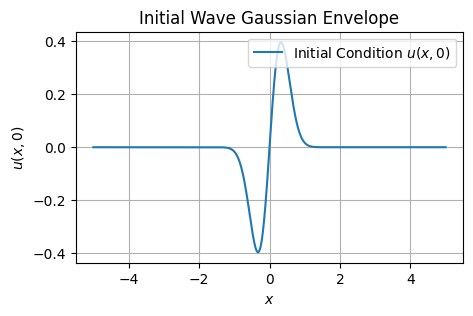

data size (225, 15, 30)
domain torch.Size([225])
initial torch.Size([15])
boundary torch.Size([30])


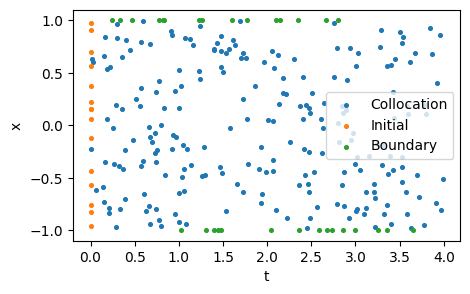

In [5]:
def plot_tx_sampler():
    tx_sampler = TXSampler(
        domain_t=(0, 4, 15),  # Time
        domain_x=(-1, 1, 15),  # Space
        boundary_sample_count=(15, 15),
    )

    domain, initial, boundary = tx_sampler.sample()

    print("data size", tx_sampler.get_data_count())
    print("domain", domain[0].shape)
    print("initial", initial[0].shape)
    print("boundary", boundary[0].shape)

    plt.figure(figsize=(5, 3))
    plt.scatter(domain[0], domain[1], label="Collocation", s=7)
    plt.scatter(initial[0], initial[1], label="Initial", s=7)
    plt.scatter(boundary[0], boundary[1], label="Boundary", s=7)
    plt.legend()

    plt.xlabel("t")
    plt.ylabel("x")


def plot_initial_condition():
    def u0_np(x, c=1, k=2, sd=0.5):
        z = k * x
        return np.sin(z) * np.exp(-((0.5 * z / sd) ** 2))

    # Generate spatial data
    x = np.linspace(-5, 5, 1000)

    # Compute initial condition
    u_initial = u0_np(x)

    # Plot the initial condition
    plt.figure(figsize=(5, 3))
    plt.plot(x, u_initial, label="Initial Condition $u(x, 0)$")
    plt.title("Initial Wave Gaussian Envelope")
    plt.xlabel("$x$")
    plt.ylabel("$u(x, 0)$")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_initial_condition()
plot_tx_sampler()

In [6]:
class Wave1D_Dataset(Dataset):
    def __init__(self, sampler: TXSampler):
        self.sampler = sampler
        collocation, initial, boundary = self.sampler.sample()
        t_c, x_c = collocation
        t_i, x_i = initial
        t_b, x_b = boundary

        # Stack t and x to create model inputs
        self.X_c = torch.stack([t_c, x_c], dim=1)
        self.X_i = torch.stack([t_i, x_i], dim=1)
        self.X_b = torch.stack([t_b, x_b], dim=1)

        self.data_size = min(len(self.X_c), len(self.X_i), len(self.X_b))
        print("Data size", self.data_size)

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        return (
            self.X_c[idx],
            self.X_i[idx],
            self.X_b[idx],
        )

In [7]:
TRAIN_SIZE = 100
train_dataset = Wave1D_Dataset(
    sampler=TXSampler(
        domain_t=(0, 4, TRAIN_SIZE),  # Time
        domain_x=(-1, 1, TRAIN_SIZE),  # Space
        boundary_sample_count=(TRAIN_SIZE**2, TRAIN_SIZE**2),
    )
)

TEST_SIZE = 20
test_dataset = Wave1D_Dataset(
    sampler=TXSampler(
        domain_t=(0, 4, TEST_SIZE),  # Time
        domain_x=(-1, 1, TEST_SIZE),  # Space
        boundary_sample_count=(TEST_SIZE**2, TEST_SIZE**2),
    )
)

Data size 10000
Data size 400


In [8]:
wave_1d_trainer = Wave1DTrainer(
    model_component=model_component,
    train_config=TrainConfig(
        batch_size=TRAIN_SIZE * 2,
        early_stopping=500,
        epoch=1000,
        lr=1e-3,
    ),
    wave_config={"c": 1, "k": 2, "std": 0.5},
    loss_weights={
        "pde": 15000,
        "ic": 0.001,
        "bc": 15000,
    },
)

wave_1d_pipeline = Pipeline(
    pipeline_name="wave_1d_mlp_2",
    trainer=wave_1d_trainer,
    data_sets=(train_dataset, test_dataset),
    pipeline_store_base_path=".pinn_models",
)

[PipelineDB]: JSON data loaded from /Users/june/Documents/project/cau/4_2/ez_pinn/.pinn_models/wave_1d_mlp_2/IeKHdPa5EtsfKI4Rw9l2oA/db.json
[PipelineDB]: JSON data loaded from /Users/june/Documents/project/cau/4_2/ez_pinn/.pinn_models/wave_1d_mlp_2/IeKHdPa5EtsfKI4Rw9l2oA/db.json
-------------------------[ WELCOME ]-------------------------
Training pipeline initialized
---------------------------------------------------------------
-------------------------[ HEALTH CHECK ]-------------------------
Pipeline is ok to go
--------------------------------------------------------------------
-------------------------[ GPU SETUP ]-------------------------
device: mps
-----------------------------------------------------------------
-------------------------[ TRAINER ]-------------------------
Dependencies injected
---------------------------------------------------------------


In [ ]:
wave_1d_pipeline.train()

-------------------------[ TRAINING ]-------------------------
Training started
----------------------------------------------------------------


Training:   0%|          | 0/50000 [00:00<?, ?it/s]/Users/june/Documents/project/cau/4_2/ez_pinn/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:  72%|███████▏  | 36161/50000 [11:34<04:40, 49.30it/s, accuracy(test)=0, accuracy(train)=0, epoch=723, loss(test)=7.56e-5, loss(train)=7.16e-5, lr=6.99e-7, tolerance=0]   

In [ ]:
wave_1d_pipeline.evaluate()

wave_1d_pipeline.plot_accuracy_history()
wave_1d_pipeline.plot_loss_history()
wave_1d_pipeline.plot_lr_history()

In [ ]:
train_loss_history = wave_1d_trainer.loss_history_train
val_loss_history = wave_1d_trainer.loss_history_validation


plt.figure(figsize=(7, 5))
epoch = np.arange(len(train_loss_history["pde"]))
plt.plot(epoch, train_loss_history["pde"], label="PDE Train")
plt.plot(epoch, train_loss_history["ic"], label="IC Train")
plt.plot(epoch, train_loss_history["bc"], label="BC Train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
epoch = np.arange(len(val_loss_history["pde"]))
plt.plot(epoch, val_loss_history["pde"], label="PDE Validation")
plt.plot(epoch, val_loss_history["ic"], label="IC Validation")
plt.plot(epoch, val_loss_history["bc"], label="BC Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot final result

In [ ]:
sampler = TXSampler(
    domain_t=(0, 4, TRAIN_SIZE),  # Time
    domain_x=(-1, 1, TRAIN_SIZE),  # Space
    boundary_sample_count=(TRAIN_SIZE**2, TRAIN_SIZE**2),
)

In [ ]:
model = wave_1d_trainer.model
model.eval()  # Set the model to evaluation mode

# Define the range of x and t
x_min, x_max = -1.0, 1.0  # Adjust based on your domain
t_min, t_max = 0.0, 4.0  # Adjust based on your time interval

# Create a grid of x and t values
num_x = 100  # Number of x points
num_t = 100  # Number of t points

x = np.linspace(x_min, x_max, num_x)
t = np.linspace(t_min, t_max, num_t)
X, T = np.meshgrid(x, t)

# Flatten the grid arrays and stack them
XT = np.stack([T.flatten(), X.flatten()], axis=1)

# Convert to torch tensor
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(get_device())
XT_tensor.requires_grad_(True)

# Compute u(x, t)
u_pred = model(XT_tensor)
u_pred = u_pred.detach().cpu().numpy()

# Reshape u_pred back to grid shape
U = u_pred.reshape(num_t, num_x)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(T, X, U, shading="auto", cmap="viridis")
plt.colorbar(label="u(x, t)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Heatmap of u(x, t)")
plt.show()

In [ ]:
# Define x values and time steps
from matplotlib.animation import FuncAnimation


x_min, x_max = -1.0, 1.0  # Adjust based on your domain
num_x = 200
x = np.linspace(x_min, x_max, num_x)

t_min, t_max = 0.0, 4.0
num_frames = 100  # Number of frames in the animation
t_values = np.linspace(t_min, t_max, num_frames)

# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
(line,) = ax.plot([], [], lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(-1.5, 1.5)  # Adjust based on expected u(x, t) values
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
ax.set_title("Oscillating String Animation")


# Function to initialize the plot
def init():
    line.set_data([], [])
    return (line,)


# Function to update the plot for each frame
def update(frame):
    t = t_values[frame]
    t_array = np.full_like(x, t)

    XT = np.stack([t_array, x], axis=1)
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(get_device())
    XT_tensor.requires_grad_(True)

    u_pred = model(XT_tensor)
    u_pred = u_pred.detach().cpu().numpy()

    line.set_data(x, u_pred)
    print(f"Frame {frame+1}/{num_frames} ({t:.2f}s), u(x, t) = {u_pred[0]}")
    ax.set_title(f"Oscillating String at t = {t:.2f}s")
    return (line,)


# Create the animation
anim = FuncAnimation(
    fig, update, init_func=init, frames=num_frames, interval=50, blit=True
)

# To save the animation as a video file (optional)
anim.save("oscillating_string.mp4", writer="ffmpeg", fps=20)

# To display the animation in a Jupyter Notebook
plt.show()